In [3]:
import pymysql
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
parser = configparser.ConfigParser()
parser.read("../config.conf")
hostname = parser.get("mysql_config","hostname")
port = parser.get("mysql_config","port")
username = parser.get("mysql_config","username")
password = parser.get("mysql_config","password")


In [5]:
conn = pymysql.connect(
                host=hostname,
                user = username,
                password = password,
                port = int(port)
        )

if conn is None:
    print("Error connecting to MySQL database")
else:
    print("MySQL connection established")

MySQL connection established


# Creating Database

In [6]:
query = """CREATE DATABASE IF NOT EXISTS dannysdiner"""
cursor = conn.cursor()
cursor.execute(query)

query = """SHOW databases;"""
cursor.execute(query)
results = cursor.fetchall()
print(f"Databases: {results}")

query = """USE dannysdiner;"""
cursor.execute(query)


Databases: (('dannysdiner',), ('information_schema',), ('mysql',), ('Orders',), ('performance_schema',), ('PokemonGo',), ('pubmed',), ('sakila',), ('sys',))


0

# Creating Tables and Inserting values

## Sales Data Table

In [7]:
query = """DROP Table IF EXISTS sales;"""
cursor = conn.cursor()
cursor.execute(query)

query = """
CREATE TABLE sales (
  customer_id VARCHAR(10),
  order_date DATE,
  product_id INTEGER
);
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()


query = """
INSERT INTO sales
  (customer_id, order_date, product_id)
VALUES 
  ('A', '2021-01-01', 1),
  ('A', '2021-01-01', 2),
  ('A', '2021-01-07', 2),
  ('A', '2021-01-10', 3),
  ('A', '2021-01-11', 3),
  ('A', '2021-01-11', 3),
  ('B', '2021-01-01', 2),
  ('B', '2021-01-02', 2),
  ('B', '2021-01-04', 1),
  ('B', '2021-01-11', 1),
  ('B', '2021-01-16', 3),
  ('B', '2021-02-01', 3),
  ('C', '2021-01-01', 3),
  ('C', '2021-01-01', 3),
  ('C', '2021-01-07', 3);
 
"""


cursor = conn.cursor()
cursor.execute(query)
conn.commit()


## Menu Data Table

In [8]:
query = """DROP Table IF EXISTS menu;"""
cursor = conn.cursor()
cursor.execute(query)

query = """
CREATE TABLE menu (
  product_id INTEGER,
  product_name VARCHAR(5),
  price INTEGER
);
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()


query = """
INSERT INTO menu
  (product_id, product_name, price)
VALUES
  (1, 'sushi', 10),
  (2, 'curry', 15),
  (3, 'ramen', 12);
 
"""


cursor = conn.cursor()
cursor.execute(query)
conn.commit()


## Customer Data Table

In [9]:
query = """DROP Table IF EXISTS members;"""
cursor = conn.cursor()
cursor.execute(query)

query = """
CREATE TABLE members (
  customer_id VARCHAR(1),
  join_date DATE
);
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()


query = """
INSERT INTO members
  (customer_id, join_date)
VALUES
  ('A', '2021-01-07'),
  ('B', '2021-01-09');;
"""


cursor = conn.cursor()
cursor.execute(query)
conn.commit()


# Case Study Questions


## 1. What is the total amount each customer spent at the restaurant

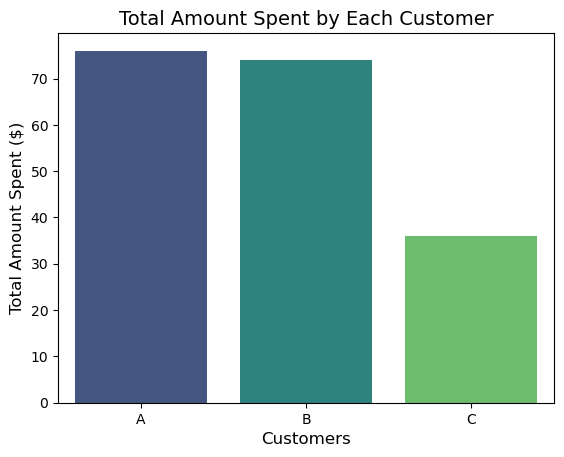

In [10]:
# SQL query for the question
query = """
SELECT
    s.customer_id,
    SUM(price) AS total_spent
FROM SALES s
    JOIN menu m 
        ON s.product_id = m.product_id
GROUP BY 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','total_spent($)'])


barplot = sns.barplot(x='customer_id', y='total_spent($)',data=df, palette="viridis")

# Add labels and title
plt.xlabel('Customers', fontsize=12)
plt.ylabel('Total Amount Spent ($)', fontsize=12)
plt.title('Total Amount Spent by Each Customer', fontsize=14)

# Show the plot
plt.show()

## 2. How many days has each customer visited the restaurant?

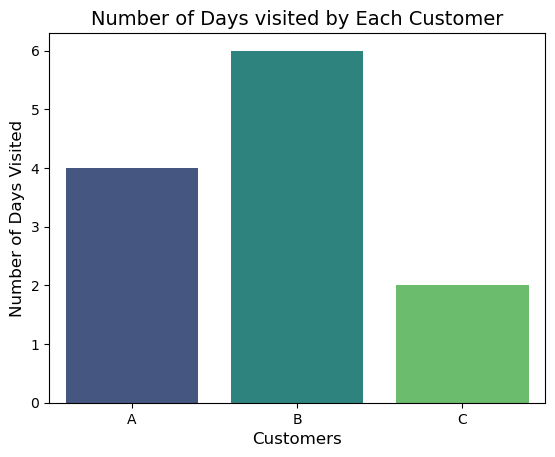

In [11]:
# SQL query for the question
query = """
SELECT
    s.customer_id,
    COUNT(DISTINCT order_date) AS no_of_days
FROM SALES s
GROUP BY 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','no_of_days'])


barplot = sns.barplot(x='customer_id', y='no_of_days',data=df, palette="viridis")

# Add labels and title
plt.xlabel('Customers', fontsize=12)
plt.ylabel('Number of Days Visited', fontsize=12)
plt.title('Number of Days visited by Each Customer', fontsize=14)

# Show the plot
plt.show()

## 3. What was the first item from the menu purchased by each customer?

In [12]:
# SQL query for the question
query = """

WITH cte AS (
SELECT
    s.customer_id,
    s.product_id,
    ROW_NUMBER() OVER(
            PARTITION BY s.customer_id
            ORDER BY s.order_date) as rnk
FROM sales s
)
SELECT
    c.customer_id,
    m.product_name
FROM cte c
    JOIN menu m
        ON c.product_id = m.product_id
WHERE rnk = 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','first_order'])

print(df)

  customer_id first_order
0           A       sushi
1           B       curry
2           C       ramen


## 4. What is the most purchased item on the menu and how many times was it purchased by all customers?

In [43]:
# SQL query for the question
query = """
SELECT
    product_name,
    COUNT(product_name) as product_count
FROM sales s
    JOIN menu m
        ON s.product_id = m.product_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['product_name','product_count'])

print(df)


print()
# SQL query for the question
query = """
with cte as 
(SELECT
    product_id,
    COUNT(product_id) as product_count
FROM sales s
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1)
SELECT 
    customer_id,
    product_name,
    COUNT(s.product_id) as product_count
FROM sales s
    JOIN menu m
        ON s.product_id = m.product_id
WHERE s.product_id = (
                    SELECT
                        c.product_id
                    FROM cte c
                )
GROUP BY 1,2;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','product_name','product_count'])

print(df)

  product_name  product_count
0        ramen              8

  customer_id product_name  product_count
0           A        ramen              3
1           B        ramen              2
2           C        ramen              3


## Which item was the most popular for each customer?

In [60]:
# SQL query for the question
query = """
with cte as 
(SELECT
    customer_id,
    product_name,
    COUNT(product_name) as product_count,
    ROW_NUMBER() OVER(
                PARTITION BY customer_id
                ORDER BY COUNT(product_name) DESC
    ) as rnk 
FROM sales s
    JOIN menu m
        ON s.product_id = m.product_id
GROUP BY 1,2
)
SELECT
    customer_id,
    product_name
FROM cte
WHERE rnk = 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','product_name'])

print(df)

  customer_id product_name
0           A        ramen
1           B        curry
2           C        ramen


## Which item was purchased first by the customer after they became a member?

In [61]:
# SQL query for the question
query = """
WITH cte AS(
SELECT
    s.customer_id,
    product_name,
    ROW_NUMBER() OVER(
        PARTITION BY s.customer_id
        ORDER BY order_date
    ) as rnk
FROM sales s
    JOIN menu m 
        ON m.product_id = s.product_id
    JOIN members c
        ON s.customer_id = c.customer_id
            AND s.order_date >= c.join_date
)
SELECT
    customer_id,
    product_name
FROM cte
WHERE rnk = 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','product_name'])

print(df)

  customer_id product_name
0           A        curry
1           B        sushi


## Which item was purchased just before the customer became a member?

In [63]:
# SQL query for the question
query = """
WITH cte AS(
SELECT
    s.customer_id,
    product_name,
    RANK() OVER(
        PARTITION BY s.customer_id
        ORDER BY order_date DESC
    ) as rnk
FROM sales s
    JOIN menu m 
        ON m.product_id = s.product_id
    JOIN members c
        ON s.customer_id = c.customer_id
            AND s.order_date < c.join_date
)
SELECT
    customer_id,
    product_name
FROM cte
WHERE rnk = 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','product_name'])

print(df)

  customer_id product_name
0           A        sushi
1           A        curry
2           B        sushi


## What is the total items and amount spent for each member before they became a member?

In [66]:
# SQL query for the question
query = """
SELECT
    s.customer_id,
    COUNT(m.product_name) AS total_items,
    SUM(m.price) AS total_amount_spent
FROM sales s
    JOIN menu m 
        ON m.product_id = s.product_id
    JOIN members c
        ON s.customer_id = c.customer_id
            AND s.order_date < c.join_date
GROUP BY 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','total_items_ordered','total_spent($)'])

print(df)

  customer_id  total_items_ordered total_spent($)
0           B                    3             40
1           A                    2             25


## If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?


In [69]:
# SQL query for the question
query = """
SELECT
    s.customer_id,
    SUM(
        CASE
            WHEN s.product_id = 1 THEN 2 * 10 * m.price
            ELSE 10 * m.price
        END
    ) as total_points
FROM sales s
    JOIN menu m 
        ON m.product_id = s.product_id
GROUP BY 1;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','total_points'])

print(df)

  customer_id total_points
0           A          860
1           B          940
2           C          360


## In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [72]:
# SQL query for the question
query = """
SELECT
    s.customer_id,
    SUM(
        CASE
            WHEN s.order_date >= c.join_date THEN 2 * 10 * m.price
            ELSE 10 * m.price
        END
    ) as total_points
FROM sales s
    JOIN menu m 
        ON m.product_id = s.product_id
    JOIN members c
        ON s.customer_id = c.customer_id
WHERE MONTH(order_date) = 1 
    AND s.customer_id in ('A','B')
GROUP BY 1
ORDER BY 2 DESC;
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()

# Results of the SQL query
results = cursor.fetchall()

df = pd.DataFrame(results, columns = ['customer_id','total_points'])

print(df)

  customer_id total_points
0           A         1270
1           B          840
